##  Code for generating network:

In [ ]:
import csv
import requests
from bs4 import BeautifulSoup
import networkx as nx

# Load CSV files
east_coast_rappers = []
west_coast_rappers = []

with open('EastCoastRappers.csv', 'r') as file:
    east_coast_rappers = [row[1] for row in csv.reader(file)]

with open('WestCoastRappers.csv', 'r') as file:
    west_coast_rappers = [row[1] for row in csv.reader(file)]

# Read the sentiment data
word_sentiments = {}
with open('Data_Set_S1.txt', 'r') as file:
    reader = csv.DictReader(file, delimiter='\t')
    for row in reader:
        word_sentiments[row['word']] = float(row['happiness_average'])

# Initialize a directed graph
G = nx.DiGraph()

# Define functions to get coast information from rapper names
def get_coast(rapper_name):
    if rapper_name in east_coast_rappers:
        return 'East Coast'
    elif rapper_name in west_coast_rappers:
        return 'West Coast'
    else:
        return None

# Function to calculate sentiment score for a text
def calculate_sentiment(text):
    words = text.split()
    sentiment_scores = [word_sentiments.get(word.lower(), 0) for word in words]
    return sum(sentiment_scores)
for rapper_list, coast in [(east_coast_rappers, 'East Coast'), (west_coast_rappers, 'West Coast')]:
    for rapper in rapper_list:
        url = f'https://en.wikipedia.org/wiki/{rapper}'
        response = requests.get(url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            content = soup.find('div', {'class': 'mw-parser-output'}).get_text()

            # Calculate sentiment score
            sentiment_score = calculate_sentiment(content)

            # Check if the linked page corresponds to a rapper in either coast list
            G.add_node(f'{rapper} ({coast})', sentiment_score=sentiment_score, coast=coast, content=content)

            links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].startswith('/wiki/') and not a['href'].startswith('/wiki/File')]

            for link in links:
                linked_rapper = link.split('/')[-1]
                linked_coast = get_coast(linked_rapper)
                if linked_coast is not None:
                    G.add_edge(f'{rapper} ({coast})', f'{linked_rapper} ({linked_coast})')

# Save the network as a GraphML file
nx.write_graphml(G, 'rapper_network_with_sentiments.graphml')


BeautifulSoup's soup.find_all('a', href=True) method finds all anchor (<a>) tags that have an href attribute. This means it's finding all the links on the Wikipedia page.

The condition if a['href'].startswith('/wiki/') and not a['href'].startswith('/wiki/File') further filters these links to include only those that start with /wiki/ (indicating a Wikipedia article link) and do not start with /wiki/File (to exclude links to file pages).

So, BeautifulSoup is using the structure of the HTML page to identify links, rather than using regular expressions. This is a common approach in web scraping when you're working with well-structured HTML documents. In this case, Wikipedia's page structure is predictable and follows certain conventions, making it easy to identify relevant links using BeautifulSoup's methods.

The use of regular expressions might be necessary if you're dealing with unstructured or semi-structured data, or if you need to extract information that doesn't follow a predictable pattern. In this case, the structure of Wikipedia pages allows us to use BeautifulSoup effectively.

# Part 1: Network visualization and basic stats


> * What is the number of nodes in the network? 
> * What is the number of links?
> * Who is the top connected rapper? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?
> * Who are the top 5 most connected east-coast rappers (again in terms of in/out-degree)? 
> * Who are the top 5 most connected west-coast rappers (again in terms of in/out-degree)?
> * Plot the in- and out-degree distributions for the whole network. 
>   * Use axes that make sense for visualizing this particular distribution.
>   * What do you observe? 
>   * Give a pedagogical explaination of why the in-degree distribution is different from the out-degree distribution?
> * Find the exponent (by using the `powerlaw` package) for the in- and out-degree distributions. What does it say about our network?
> * Compare the two degree distributions two the degree distribution of a *random network* (undirected) with the same number of nodes and probability of connection *p*. Comment your results.

_Exercise 1b_: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (directed) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on either the Force Atlas 2 algorithm, or the built-in algorithms for networkX;
>   * Whatever else you feel like that would make the visualization nicer.
> * Describe the structure you observe. What useful information can you decipher from this?

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

# Load the graph
G = nx.read_graphml('rapper_network_with_sentiments.graphml')

# Remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))


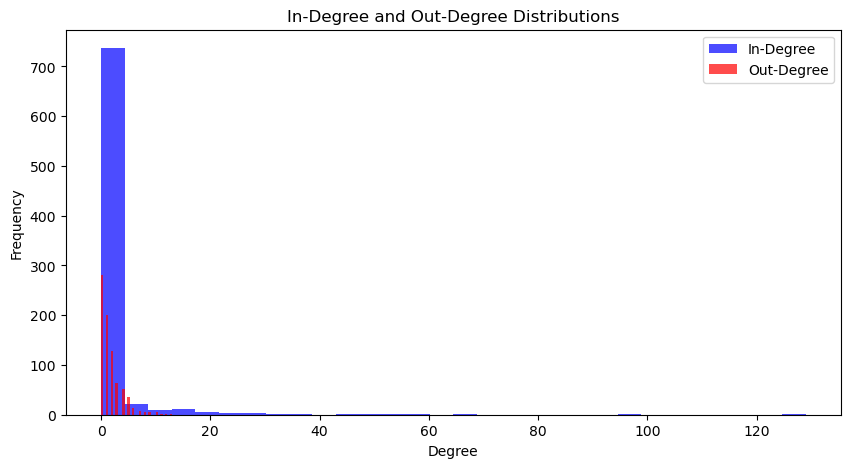

Number of nodes: 801
Number of links: 1366
Top In-Degree Connected Rapper: Jay-Z (East Coast) (In-Degree: 129)
Top Out-Degree Connected Rapper: Dr. Dre (West Coast) (Out-Degree: 13)
Top 5 Most Connected East-Coast Rappers (In-Degree): ['Jay-Z (East Coast)', 'Nas (East Coast)', 'Jadakiss (East Coast)', 'KRS-One (East Coast)', 'Fabolous (East Coast)']
Top 5 Most Connected East-Coast Rappers (Out-Degree): ['50 Cent (East Coast)', 'Kool G Rap (East Coast)', 'Method Man (East Coast)', 'Nas (East Coast)', 'Freddie Foxxx (East Coast)']
Top 5 Most Connected West-Coast Rappers (In-Degree): ['E-40 (West Coast)', 'Kurupt (West Coast)', 'Ice-T (West Coast)', 'Xzibit (West Coast)', 'B-Legit (West Coast)']
Top 5 Most Connected West-Coast Rappers (Out-Degree): ['Dr. Dre (West Coast)', 'Kendrick Lamar (West Coast)', 'DJ Dahi (West Coast)', 'RBX (West Coast)', 'Snoop Dogg (West Coast)']


In [44]:
import networkx as nx
import matplotlib.pyplot as plt

# Number of nodes and links
num_nodes = G.number_of_nodes()
num_links = G.number_of_edges()

# Top connected rapper
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())
top_in_connected_rapper = max(in_degrees, key=in_degrees.get)
top_out_connected_rapper = max(out_degrees, key=out_degrees.get)

# Top 5 most connected east-coast rappers
east_coast_rappers = [node for node in G.nodes if 'East Coast' in node]
east_coast_in_degrees = {rapper: in_degrees[rapper] for rapper in east_coast_rappers}
east_coast_out_degrees = {rapper: out_degrees[rapper] for rapper in east_coast_rappers}
top_5_east_coast_in_connected_rappers = sorted(east_coast_in_degrees, key=east_coast_in_degrees.get, reverse=True)[:5]
top_5_east_coast_out_connected_rappers = sorted(east_coast_out_degrees, key=east_coast_out_degrees.get, reverse=True)[:5]

# Top 5 most connected west-coast rappers
west_coast_rappers = [node for node in G.nodes if 'West Coast' in node]
west_coast_in_degrees = {rapper: in_degrees[rapper] for rapper in west_coast_rappers}
west_coast_out_degrees = {rapper: out_degrees[rapper] for rapper in west_coast_rappers}
top_5_west_coast_in_connected_rappers = sorted(west_coast_in_degrees, key=west_coast_in_degrees.get, reverse=True)[:5]
top_5_west_coast_out_connected_rappers = sorted(west_coast_out_degrees, key=west_coast_out_degrees.get, reverse=True)[:5]

# Plot degree distributions
in_degrees_values = list(in_degrees.values())
out_degrees_values = list(out_degrees.values())

plt.figure(figsize=(10, 5))
plt.hist(in_degrees_values, bins=30, alpha=0.7, color='b', label='In-Degree')
plt.hist(out_degrees_values, bins=30, alpha=0.7, color='r', label='Out-Degree')
plt.title('In-Degree and Out-Degree Distributions')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Print results
print(f'Number of nodes: {num_nodes}')
print(f'Number of links: {num_links}')
print(f'Top In-Degree Connected Rapper: {top_in_connected_rapper} (In-Degree: {in_degrees[top_in_connected_rapper]})')
print(f'Top Out-Degree Connected Rapper: {top_out_connected_rapper} (Out-Degree: {out_degrees[top_out_connected_rapper]})')
print(f'Top 5 Most Connected East-Coast Rappers (In-Degree): {top_5_east_coast_in_connected_rappers}')
print(f'Top 5 Most Connected East-Coast Rappers (Out-Degree): {top_5_east_coast_out_connected_rappers}')
print(f'Top 5 Most Connected West-Coast Rappers (In-Degree): {top_5_west_coast_in_connected_rappers}')
print(f'Top 5 Most Connected West-Coast Rappers (Out-Degree): {top_5_west_coast_out_connected_rappers}')

In [45]:
import powerlaw
import numpy as np

# Calculate in-degree distribution
in_degrees_values = list(dict(G.in_degree()).values())
out_degrees_values = list(dict(G.out_degree()).values())

# Fit power-law distribution for in-degrees
fit_in_degree = powerlaw.Fit(in_degrees_values, discrete=True)

# Fit power-law distribution for out-degrees
fit_out_degree = powerlaw.Fit(out_degrees_values, discrete=True)

p = np.mean(in_degrees_values) / (num_nodes - 1)  
random_network = nx.erdos_renyi_graph(num_nodes, p)

random_in_degrees_values = list(dict(random_network.degree()).values())

fit_random_in_degree = powerlaw.Fit(random_in_degrees_values, discrete=True)

print(f'Exponent for in-degree distribution: {fit_in_degree.power_law.alpha}')
print(f'Exponent for out-degree distribution: {fit_out_degree.power_law.alpha}')
print(f'Exponent for random network in-degree distribution: {fit_random_in_degree.power_law.alpha}')


Exponent for in-degree distribution: 2.4009629291654013
Exponent for out-degree distribution: 3.8936916581962313
Exponent for random network in-degree distribution: 4.23477192383638


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


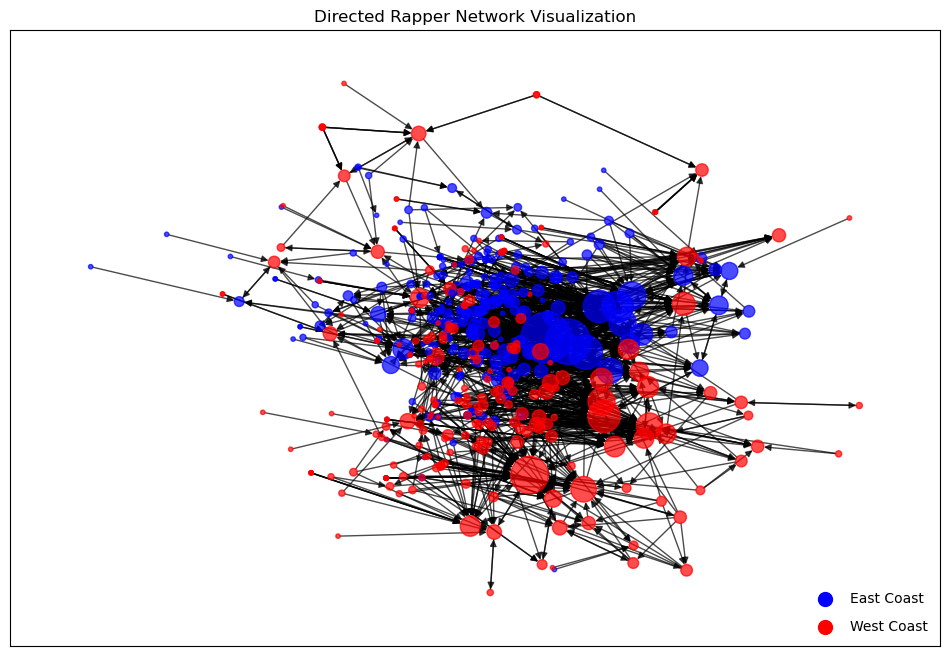

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

node_colors = []
for node in G.nodes:
    if 'East Coast' in node:
        node_colors.append('blue')
    else:
        node_colors.append('red')

node_sizes = [10 * G.degree(node) for node in G.nodes]

positions = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 8))
nx.draw_networkx(
    G, 
    pos=positions, 
    node_color=node_colors, 
    node_size=node_sizes,
    with_labels=False, 
    alpha=0.7
)

plt.scatter([], [], c='blue', s=100, label='East Coast')
plt.scatter([], [], c='red', s=100, label='West Coast')
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, loc='lower right')

plt.title('Directed Rapper Network Visualization')
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nedan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


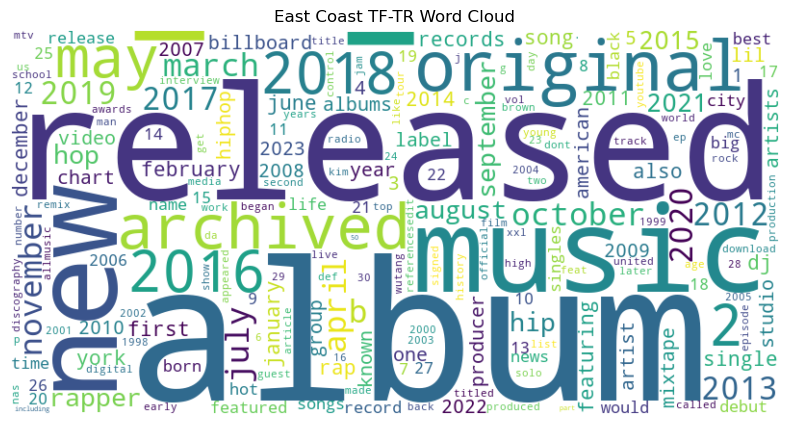

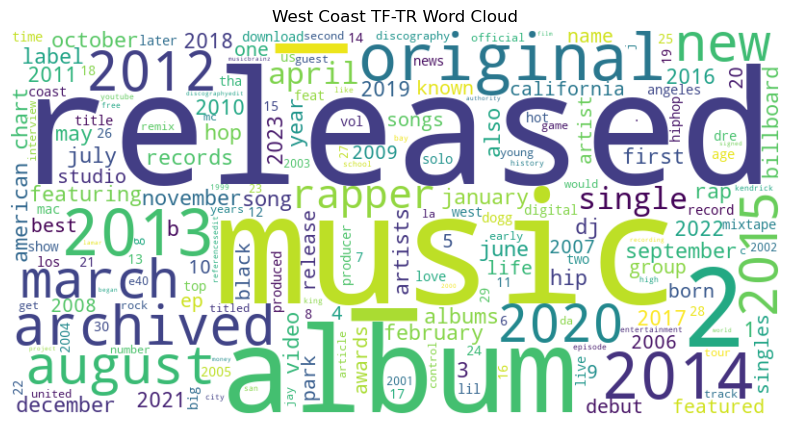

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import networkx as nx
import string

G = nx.read_graphml('rapper_network_with_sentiments.graphml')

G.remove_edges_from(nx.selfloop_edges(G))


def extract_and_clean_text_for_coast(coast):
    text = ''
    stop_words = set(stopwords.words('english'))  
    translator = str.maketrans('', '', string.punctuation) 

    for node in G.nodes:
        if coast in node:
            content = G.nodes[node].get('content', '')  
            
            content = content.translate(translator).lower()
            
            text += content + ' '

    tokens = nltk.word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in stop_words]

    cleaned_text = ' '.join(cleaned_tokens)

    return cleaned_text

east_coast_cleaned_text = extract_and_clean_text_for_coast('East Coast')
west_coast_cleaned_text = extract_and_clean_text_for_coast('West Coast')


def calculate_tf_tr(text):
    words = text.split()
    tf = {word: words.count(word) for word in set(words)}
    
    max_tf = max(tf.values())
    tr = {word: tf[word] * (1 - (tf[word] / max_tf)) for word in tf}
    
    return tr

east_coast_tf_tr = calculate_tf_tr(east_coast_cleaned_text)
west_coast_tf_tr = calculate_tf_tr(west_coast_cleaned_text)

def generate_tf_tr_word_cloud(tf_tr_scores, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tf_tr_scores)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_tf_tr_word_cloud(east_coast_tf_tr, 'East Coast TF-TR Word Cloud')
generate_tf_tr_word_cloud(west_coast_tf_tr, 'West Coast TF-TR Word Cloud')


### Sentiment

#### Average the average sentiment of the nodes in each community to find a community-level sentiment.

In [227]:
G = nx.read_graphml('rapper_network.graphml')

G.remove_edges_from(nx.selfloop_edges(G))
network_ud = G.to_undirected()

west_coast_nodes = [node for node, data in network_ud.nodes(data=True) if data['coast'] == 'West']
east_coast_nodes = [node for node, data in network_ud.nodes(data=True) if data['coast'] == 'East']

network_east_coast = G.subgraph(east_coast_nodes).copy().to_undirected()
network_west_coast = G.subgraph(west_coast_nodes).copy().to_undirected()

In [228]:
def louvain_alg(network, Print):
    # compute the best partition
    partition = nx.community.louvain_communities(network)
    if Print==True:
        size = float(len(partition))
        pos = nx.spring_layout(network)
        count = 0.
        for com in set(partition.values()) :
            count = count + 1.
            list_nodes = [nodes for nodes in com]
            nx.draw_networkx_nodes(network, pos, list_nodes, node_size = 20,
                                            node_color = str(count / size))
            nx.draw_networkx_edges(network,pos, alpha=0.5)
        plt.show()
    else:
        return partition

In [231]:
partition_ec = louvain_alg(network_east_coast, False)

partition_wc = louvain_alg(network_west_coast, False)


In [210]:
G = nx.read_graphml('rapper_network_with_sentiments2.graphml')

G.remove_edges_from(nx.selfloop_edges(G))

In [211]:
community_sentiments_ec = []

for community in partition_ec:
    community_sentiment_sum = 0
    num_nodes = len(community)
    
    for node in community:
        sentiment_score = G.nodes[node].get('sentiment_score', 0)
        community_sentiment_sum += sentiment_score
    
    if num_nodes > 0:
        average_sentiment = community_sentiment_sum / num_nodes
        community_sentiments_ec.append(average_sentiment)
    else:
        community_sentiments_ec.append(0)

In [212]:
community_sentiments_wc = []

for community in partition_wc:
    community_sentiment_sum = 0
    num_nodes = len(community)
    
    for node in community:
        sentiment_score = G.nodes[node].get('sentiment_score', 0)
        community_sentiment_sum += sentiment_score
    
    if num_nodes > 0:
        average_sentiment = community_sentiment_sum / num_nodes
        community_sentiments_wc.append(average_sentiment)
    else:
        community_sentiments_wc.append(0)

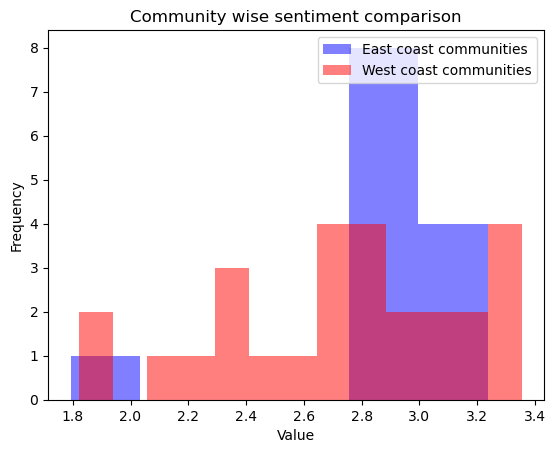

In [213]:
import matplotlib.pyplot as plt

plt.hist(community_sentiments_ec, bins=len(community_sentiments_ec)//2, color='blue', alpha=0.5, label='East coast communities')

plt.hist(community_sentiments_wc, bins=len(community_sentiments_wc)//2, color='red', alpha=0.5, label='West coast communities')

plt.legend(loc='upper right')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Community wise sentiment comparison')

# Show the plot
plt.show()

# Part 4: Sentiment of communities


#### Calculate and store sentiment for every rapper

Reading the sentiment words from the Data_Set_S1.txt file and placing each word to a corresponding sentiment score in a dictionary called word_sentiments. Then each node in the graph is traversed, the rapper's name associated with this node is used to open the corresponding text file that holds the wikipedia page content. This content is read through and each word is compared to the words in the sentiment_words dictionary to find words that impacts the total sentiment score. The total sum of sentiment scores is divided by the number of sentiment words appearing in the text, to normalize it across the wikipedia pages, such that rappers with an extensive wikipedia page does not seem more "happy" just due to the amount of words. This normalized sentiment value for each rappers wikipedia page is set as a nodal property called sentiment_score. 

In [232]:
import csv
import os
import networkx as nx

G = nx.read_graphml('rapper_network.graphml')

G.remove_edges_from(nx.selfloop_edges(G))

word_sentiments = {}
with open('Data_Set_S1.txt', 'r') as file:
    reader = csv.DictReader(file, delimiter='\t')
    for row in reader:
        word_sentiments[row['word']] = float(row['happiness_average'])

for rapper in G.nodes():
    rapper_name = rapper.strip()
    rapper_name = rapper_name.replace(" ","_")
    
    text_file_path = os.path.join('text_data', f'{rapper_name}.txt') 
    
    if os.path.exists(text_file_path):
        with open(text_file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            
            words = text.split()
            sentiment_words = [word for word in words if word.lower() in word_sentiments]
            num_sentiment_words = len(sentiment_words)
            
            sentiment_scores = [word_sentiments[word.lower()] for word in sentiment_words]
            sentiment_score_per_word = sum(sentiment_scores) / max(num_sentiment_words, 1)
            
            G.nodes[rapper]['sentiment_score'] = sentiment_score_per_word
    else:
        G.nodes[rapper]['sentiment_score'] = 0

nx.write_graphml(G, 'rapper_network_with_sentiments.graphml')



#### Create a histogram of all rappers' associated sentiments.
#### What are the 10 rappers with happiest and saddest pages?


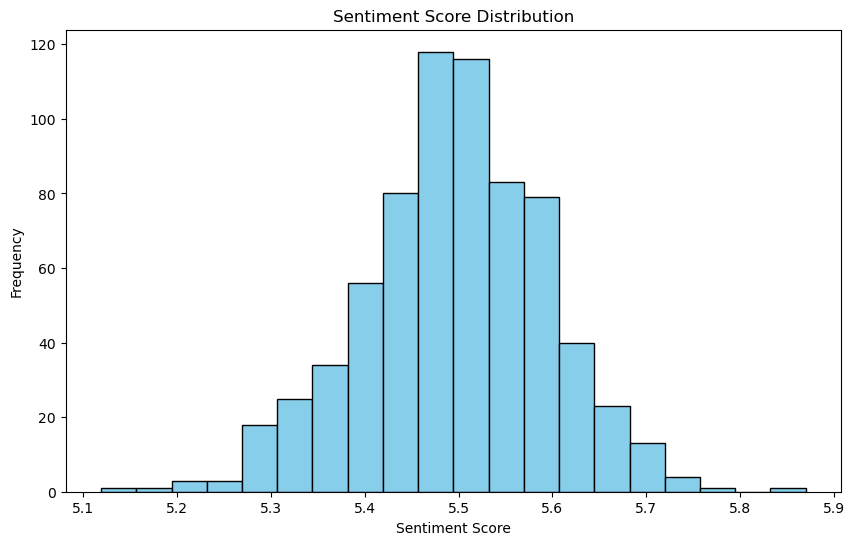

In [233]:
import matplotlib.pyplot as plt

sentiment_scores = [G.nodes[rapper].get('sentiment_score', 0) for rapper in G.nodes() if G.nodes[rapper].get('sentiment_score', 0) != 0]

plt.figure(figsize=(10, 6))
plt.hist(sentiment_scores, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')
plt.show()


Provided here is a histogram of the sentiment scores across all the rappers in the network. Just by looking at the range of the sentiment scores, it is evident that they are very centered and not at all diverse. This is attributed to the fact that certain stop words are given an individual sentiment score, and wikipedia pages are full of these stop words, making the overall sentiment scores to be very alike. We have decided to go ahead and remove the stop words from the collection of sentiment words, as this will hopefully display a more accurate range and difference between the rappers, even though this difference might not be as clear on their wikipedia page, as their song lyrics.

In [234]:
top_happiest_rappers = [rapper for rapper in G.nodes() if G.nodes[rapper].get('sentiment_score', 0) != 0]
top_happiest_rappers = sorted(top_happiest_rappers, key=lambda x: G.nodes[x].get('sentiment_score', 0), reverse=True)[:10]

top_saddest_rappers = [rapper for rapper in G.nodes() if G.nodes[rapper].get('sentiment_score', 0) != 0]
top_saddest_rappers = sorted(top_saddest_rappers, key=lambda x: G.nodes[x].get('sentiment_score', 0))[:10]

print(f'Top 10 Happiest Rappers:')
for i, rapper in enumerate(top_happiest_rappers):
    sentiment_score = G.nodes[rapper].get('sentiment_score', 0)
    print(f'{i+1}. {rapper} - Sentiment Score: {sentiment_score}')

print(f'\nTop 10 Saddest Rappers:')
for i, rapper in enumerate(top_saddest_rappers):
    sentiment_score = G.nodes[rapper].get('sentiment_score', 0)
    print(f'{i+1}. {rapper} - Sentiment Score: {sentiment_score}')

Top 10 Happiest Rappers:
1. DJ Webstar - Sentiment Score: 5.869523809523811
2. Young Music DYMG - Sentiment Score: 5.761223776223779
3. Like (record producer) - Sentiment Score: 5.752947368421056
4. Foreknown (rapper) - Sentiment Score: 5.750107526881721
5. D Smoke - Sentiment Score: 5.746411290322583
6. Justina Valentine - Sentiment Score: 5.7341787439613565
7. Mann (rapper) - Sentiment Score: 5.718768115942028
8. M. K. Asante - Sentiment Score: 5.717524893314363
9. Speak! - Sentiment Score: 5.7172093023255846
10. Sky Blu (rapper) - Sentiment Score: 5.710287356321845

Top 10 Saddest Rappers:
1. Slip Capone - Sentiment Score: 5.1195219123506
2. Ol' Dirty Bastard - Sentiment Score: 5.177684331797223
3. Slow Pain - Sentiment Score: 5.222363636363641
4. Hell Rell - Sentiment Score: 5.223678756476688
5. Killa Sin - Sentiment Score: 5.230952380952383
6. AR-Ab - Sentiment Score: 5.255431841831412
7. Isaiah Toothtaker - Sentiment Score: 5.261173708920186
8. Jimmy Wopo - Sentiment Score: 5.262

#### Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).

In [149]:
east_coast_rappers = [rapper for rapper in G.nodes() if G.nodes[rapper].get('coast', '').strip() == "East" and G.nodes[rapper].get('sentiment_score', 0) != 0]
west_coast_rappers = [rapper for rapper in G.nodes() if G.nodes[rapper].get('coast', '').strip() == "West" and G.nodes[rapper].get('sentiment_score', 0) != 0]

avg_sentiment_east = sum(G.nodes[rapper]['sentiment_score'] for rapper in east_coast_rappers) / max(len(east_coast_rappers), 1)
avg_sentiment_west = sum(G.nodes[rapper]['sentiment_score'] for rapper in west_coast_rappers) / max(len(west_coast_rappers), 1)

happiest_coast = 'East Coast' if avg_sentiment_east > avg_sentiment_west else 'West Coast'
saddest_coast = 'West Coast' if avg_sentiment_east > avg_sentiment_west else 'East Coast'

print(f'The happiest coast is {happiest_coast} with an average sentiment score per word of {max(avg_sentiment_east, avg_sentiment_west)}.')
print(f'The saddest coast is {saddest_coast} with an average sentiment score per word of {min(avg_sentiment_east, avg_sentiment_west)}.')


The happiest coast is West Coast with an average sentiment score per word of 5.503939260910425.
The saddest coast is East Coast with an average sentiment score per word of 5.490007541361812.


There is very little difference between the sentiment scores across the two coasts.

### Removing stopwords from sentiment database

In [235]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
sentiment_stop = []
with open('Data_Set_S1.txt', 'r') as file:
    next(file)
    
    for line in file:
        word = line.strip().split('\t')[0].lower()
        if word in stop_words:
            sentiment_stop.append(word)
            
print("Out of the total ", len(sentiment_stop),
      "stop words that appear in the Data_Set_S1.txt file, here is presented 30 of them:\n",sentiment_stop[:30])

Out of the total  162 stop words that appear in the Data_Set_S1.txt file, here is presented 30 of them:
 ['won', 'me', 'haven', 'we', 'myself', 'more', 'you', 'yours', 'yourself', 'all', 'most', 'she', 'my', 'own', 'up', 'very', 'herself', 'ma', 'our', 'will', 'ours', 'ourselves', 'above', 'i', 'both', 'now', 'being', 'her', 'have', 'having']


This list showcases why we are interested in not adressing these words when doing the sentiment analysis for the rappers' wikipedia page, and instead focusing more on words with actual meaning towards the happiness / sadness score.

#### Calculate and store sentiment for every rapper

The stop words are then filtered out here by a simple check; if the word in the wikipediage text for the individual rapper is part of the nltk english stop word corpus, it will not count towards the total sentiment score.

In [236]:
import csv
import os
import nltk

import networkx as nx

G = nx.read_graphml('rapper_network.graphml')
G.remove_edges_from(nx.selfloop_edges(G))

word_sentiments = {}
with open('Data_Set_S1.txt', 'r') as file:
    reader = csv.DictReader(file, delimiter='\t')
    for row in reader:
        word_sentiments[row['word']] = float(row['happiness_average'])

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

for rapper in G.nodes():
    rapper_name = rapper.strip() 
    rapper_name = rapper_name.replace(" ","_")
    
    text_file_path = os.path.join('text_data', f'{rapper_name}.txt') 
    
    if os.path.exists(text_file_path):
        with open(text_file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            
            words = text.split()
            filtered_words = [word for word in words if word.lower() not in stop_words] # New check here
            num_words = len(filtered_words)
            
            sentiment_scores = [word_sentiments.get(word.lower(), 0) for word in filtered_words]
            sentiment_score_per_word = sum(sentiment_scores) / max(num_words, 1)
            
            G.nodes[rapper]['sentiment_score'] = sentiment_score_per_word
    else:
        G.nodes[rapper]['sentiment_score'] = 0

nx.write_graphml(G, 'rapper_network_with_sentiments2.graphml')


#### Create a histogram of all rappers' associated sentiments.
#### What are the 10 rappers with happiest and saddest pages?

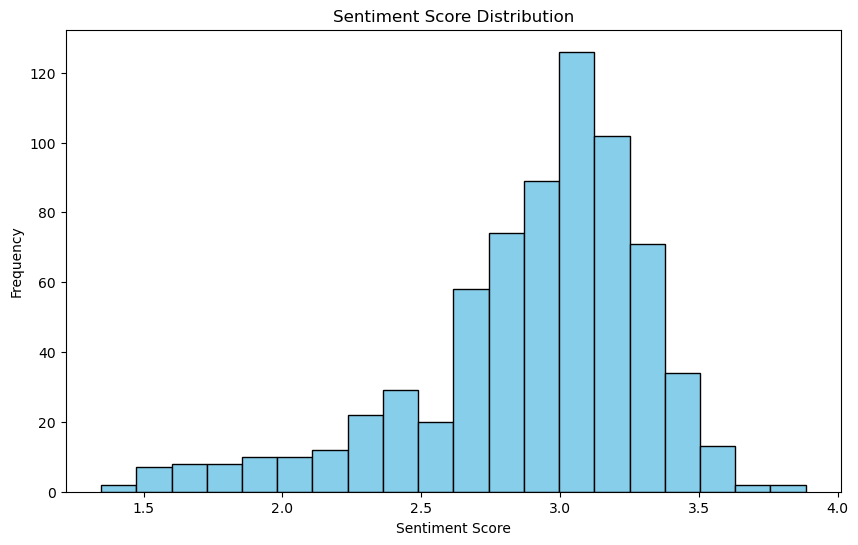

In [237]:
import matplotlib.pyplot as plt

G = nx.read_graphml('rapper_network_with_sentiments2.graphml')
G.remove_edges_from(nx.selfloop_edges(G))

sentiment_scores = [G.nodes[rapper].get('sentiment_score', 0) for rapper in G.nodes() if G.nodes[rapper].get('sentiment_score', 0) != 0]

plt.figure(figsize=(10, 6))
plt.hist(sentiment_scores, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Distribution')
plt.show()

With the removal of the stop words, there is a clear shift in the level of sentiment scores towards a more saddening score. Also evident is the now more diverse range of sentiment scores across the rappers, really showcasing how much the stop words impacted the sentiment scores. By looking further into these results however, and comparing the lowest scoring rapper to the highest scoring rapper and the content of their wikipedia pages, it is clear how the distinction comes to be. For the lowest scoring rapper ("Neo da Matrix"), his content is mainly the names of his songs, which actually do seem to follow a more saddening path. The rapper with the highest score ("Dave Free") has content on his wikipedia page, that is heavily impacted with awards and nominations, where more positive words are appearing more often. Here the distinction does not come from the rappers' individual contributions, but more so from the wordings used to describe the rappers' professional career. With that in mind, the sentiment score might be able to reflect how well a rapper has performed in terms of winnings, nominations and overall positive career reinforcements.

In [238]:

top_happiest_rappers = [rapper for rapper in G.nodes() if G.nodes[rapper].get('sentiment_score', 0) != 0]
top_happiest_rappers = sorted(top_happiest_rappers, key=lambda x: G.nodes[x].get('sentiment_score', 0), reverse=True)[:10]

top_saddest_rappers = [rapper for rapper in G.nodes() if G.nodes[rapper].get('sentiment_score', 0) != 0]
top_saddest_rappers = sorted(top_saddest_rappers, key=lambda x: G.nodes[x].get('sentiment_score', 0))[:10]

print(f'Top 10 Happiest Rappers:')
for i, rapper in enumerate(top_happiest_rappers):
    sentiment_score = G.nodes[rapper].get('sentiment_score', 0)
    print(f'{i+1}. {rapper} - Sentiment Score: {sentiment_score}')

print(f'\nTop 10 Saddest Rappers:')
for i, rapper in enumerate(top_saddest_rappers):
    sentiment_score = G.nodes[rapper].get('sentiment_score', 0)
    print(f'{i+1}. {rapper} - Sentiment Score: {sentiment_score}')


Top 10 Happiest Rappers:
1. Dave Free - Sentiment Score: 3.8848101265822796
2. DJ Jazzy Joyce - Sentiment Score: 3.7954000000000043
3. Dom Kennedy - Sentiment Score: 3.7455846994535538
4. Doug E. Fresh - Sentiment Score: 3.6478404512489995
5. Ali Vegas - Sentiment Score: 3.5816981132075467
6. Lloyd Banks - Sentiment Score: 3.57917615539183
7. DJ Charlie Chase - Sentiment Score: 3.5720110192837513
8. Charles Hamilton (rapper) - Sentiment Score: 3.564622950819681
9. Jay Park - Sentiment Score: 3.5574732772344686
10. GaTa - Sentiment Score: 3.5551569506726457

Top 10 Saddest Rappers:
1. Neo da Matrix - Sentiment Score: 1.3470894308943084
2. Sha Money XL - Sentiment Score: 1.4248005908419499
3. Cardiak - Sentiment Score: 1.4953392130257803
4. Knxwledge - Sentiment Score: 1.5530949105914713
5. Willie B (producer) - Sentiment Score: 1.5672663139329799
6. Focus... - Sentiment Score: 1.5673152173913036
7. DJ Dahi - Sentiment Score: 1.5798749478949587
8. Buckwild (music producer) - Sentiment Sc

#### Which is the happiest and which is saddest coast according to the LabMT wordlist approach? (Take the coast's sentiment to be the average sentiment of the coast's rappers' pages (disregarding any rappers with sentiment 0).

In [154]:
east_coast_rappers = [rapper for rapper in G.nodes() if G.nodes[rapper].get('coast', '').strip() == "East" and G.nodes[rapper].get('sentiment_score', 0) != 0]
west_coast_rappers = [rapper for rapper in G.nodes() if G.nodes[rapper].get('coast', '').strip() == "West" and G.nodes[rapper].get('sentiment_score', 0) != 0]

avg_sentiment_east = sum(G.nodes[rapper]['sentiment_score'] for rapper in east_coast_rappers) / max(len(east_coast_rappers), 1)
avg_sentiment_west = sum(G.nodes[rapper]['sentiment_score'] for rapper in west_coast_rappers) / max(len(west_coast_rappers), 1)

happiest_coast = 'East Coast' if avg_sentiment_east > avg_sentiment_west else 'West Coast'
saddest_coast = 'West Coast' if avg_sentiment_east > avg_sentiment_west else 'East Coast'

print(f'The happiest coast is {happiest_coast} with an average sentiment score per word of {max(avg_sentiment_east, avg_sentiment_west)}.')
print(f'The saddest coast is {saddest_coast} with an average sentiment score per word of {min(avg_sentiment_east, avg_sentiment_west)}.')


The happiest coast is East Coast with an average sentiment score per word of 2.9124051932258075.
The saddest coast is West Coast with an average sentiment score per word of 2.8779613896383043.


There is still very small to no difference in average sentiment between the two coasts.

#### Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.

Here the label shuffling test is performed to see if the east coast will have a significantly higher sentiment than a randomly selected group of rappers of the same size, with a 5% confidence bound. The shuffling is happening by performing a random shuffling and setting nodal property "coast" of the first X (amount of east coast rappers) in the list of nodes of this cloned network to "East". The remaining nodes / rappers will be attributed to the west coast, and the graph is traversed to find the sentiment scores of the east coast rappers in this newly created graph clone. These scores are averaged and appended to a list. In the end it is evident that the original partitioning of rappers in the east coast is in the high end of the distribution, after performing this label shuffling test, but nevertheless not in the top 5% of the 1000 iterations. This result alone is sort of expected given the small difference between the east coast and the west coast rappers as presented earlier. Provided the size of the groups, east coast rappers and west coast rappers, is not too far apart, one can expect a great overlap in the rappers included in the "East coast" rapper group at every random shuffling iteration. If the amount of rappers in the east coast grouping was further from the amount of rappers in the west coast grouping, we could expect the result to be different, while also taking into account that the sentiment levels across the groups would differ more in that regard.

In [220]:
import random
import copy

num_iterations = 1000
nr_east_coast_rappers = len([rapper for rapper in G.nodes() if G.nodes[rapper].get('coast', '').strip() == "East"])
average_sentiments = []

for _ in range(num_iterations):
    G_clone = copy.deepcopy(G)
    
    rappers = list(G_clone.nodes())
    
    random.shuffle(rappers)
    
    for rapper in rappers[:nr_east_coast_rappers]:
        G_clone.nodes[rapper]['coast'] = 'East'
    for rapper in rappers[nr_east_coast_rappers:]:
        G_clone.nodes[rapper]['coast'] = 'West'
    
    east_coast_rappers_clone = [rapper for rapper in G_clone.nodes() if G_clone.nodes[rapper].get('coast', '').strip() == 'East' and G_clone.nodes[rapper].get('sentiment_score', 0) != 0]
    avg_sentiment_east_clone = sum(G_clone.nodes[rapper]['sentiment_score'] for rapper in east_coast_rappers_clone) / max(len(east_coast_rappers_clone), 1)
    
    average_sentiments.append(avg_sentiment_east_clone)

confidence_bound_east = sorted(average_sentiments)[int(0.95 * num_iterations)]

num_exceedances_east = sum(1 for sentiment in average_sentiments if sentiment >= avg_sentiment_east)

print(f'Observed average sentiment for East Coast: {avg_sentiment_east:.2f}')
print(f'5% confidence bound for East Coast: {confidence_bound_east:.2f}')
print(f'Number of exceedances for East Coast: {num_exceedances_east}')


Observed average sentiment for East Coast: 2.91
5% confidence bound for East Coast: 2.92
Number of exceedances for East Coast: 168
